# Dynamic Time Warping

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.metrics import dtw
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tqdm import tqdm
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns

%run ../sys_configs.ipynb
np.random.seed(123)

## Introduction

The DTW metric considers *warping paths* through the pair of time series, which we can denote $X = (x_{1}, .., x_{p})$ and $Y = (y_{1}, ..., y_{q})$ where $x_{i} \in \mathbb{R}^{6}$, $y_{j} \in \mathbb{R}^{6}$. In the problem setup with the overlapping sliding windows, $n = m$. 

In the pairwise cost matrix considered at each time step $C_{ij} = f(x_{i} , y_{j})$, we use the L2-Norm across all 6 dimensions, i.e. $f(x_{i}, y_{j}) = \sqrt{(x_{i,1}-y_{j,1})^{2} + ... + (x_{i,6}-y_{j,6})^{2}}$. 

A warping path advances exactly one step through at least one of the time series at each stage, choosing which (or both) in such a way as to minimise the total overall warping path cost. The DTW Score is the minimum cost among all warping paths P, i.e. $DTW(X, Y) = min_{p \in P}C_{p}(X, Y)$

The below code will be used to visualise a random sample of the time series, the true labels and the label predicted by the DTW methods.

In [2]:
def plot_samples(data, labels, predictions):
    N = len(data)
    
    n_rows, n_cols = 5, 2
    random_idx = np.random.choice(N, n_rows * n_cols, replace=False)
    fig, axes = plt.subplots(n_rows, n_cols, sharex=True, figsize=(25,10))
    fig.subplots_adjust(hspace=0.3, wspace=0.05)

    for n, i in enumerate(random_idx):
        data_ = data[i, :, :]
        label = ACTIVITY_MAPPING.get(labels[i])
        prediction = ACTIVITY_MAPPING.get(predictions[i])

        row = n // n_cols
        col = n % n_cols
        # accelerometer channel data
        axes[row, col].plot(data_[:, 0], color = scale_rgb(COLOURS.get("accent-blue-dark-3")))
        axes[row, col].plot(data_[:, 1], color = scale_rgb(COLOURS.get("accent-blue-light-3")))
        axes[row, col].plot(data_[:, 2], color = scale_rgb(COLOURS.get("accent-blue-light-1")))

        # gyroscope channel data
        axes[row, col].plot(data_[:, 3], color = scale_rgb(COLOURS.get("accent-grey-dark-1")))
        axes[row, col].plot(data_[:, 4], color = scale_rgb(COLOURS.get("accent-grey-light-3")))
        axes[row, col].plot(data_[:, 5], color = scale_rgb(COLOURS.get("accent-grey-light-1")))

        axes[row, col].get_xaxis().set_visible(False)
        axes[row, col].get_yaxis().set_visible(False)
        axes[row, col].text(0.5, -0.125, f'Target:{label}\nPrediction:{prediction}', transform=axes[row, col].transAxes, verticalalignment="center", horizontalalignment = "center")

    plt.show()

## Approach 1: K- Nearest Neighbour & DTW Barycentres

### Approach

A single DTW pair comparison is $O(pq)$. The window size used in this work is 250, so DTW struggles to scale. Using DTW in a KNN classifier is also unrealistic as the train dataset has size N $\approx 10^{3}$. The prediction stage of KNN-DTW has order $O(Npq)$! This is infeasible for making near real-time predictions. 

Therefore, we compute DTW Barycenters using the methodology introduced in [1] for each class, and loosely consider these as central *average* time series' representative of their parent classes. They are chosen to minimise the sum of DTW distances to all time series in the set and are analagous to the centroid in K-means clustering, which uses the sum of squared Euclidean distances.

The advantage of using DTW Barycenters is that there is exactly 1 per class, so the N in the $O(Npq)$ KNN prediction operation is 31, making the problem ameniable to near real-time classification.

Begin by reading in the sampled data produced by window method 1. We read in a sampled version; the original suffered from a major class imbalance problem. 

In [3]:
with open('../data/1s_train.npy', 'rb') as f:
    x1s_train = np.load(f)
    y1s_train = np.load(f)
sz, dim = x1s_train.shape[1:]
    
with open('../data/1s_val.npy', 'rb') as f:
    x1s_val = np.load(f)
    y1s_val = np.load(f)

### Training

Iterate through each class and compute the barycenter. Each barycenter is of size *Time series window length x dimensionality.*

In [4]:
barycenters = np.zeros((31, sz, dim)) # Number of classes x Time series window length x Dimensionality
classes = np.unique(y1s_train)

In [5]:
start_time = time.time()
for idx, c in tqdm(enumerate(classes), desc ="Finding Barycenters"):
    data = x1s_train[y1s_train == c, :, :]
    barycenter = dtw_barycenter_averaging(data, max_iter=5, tol=1e-5) # max_iter = 5 was found to be sufficient during testing
    barycenters[idx] = barycenter
print("--- %s seconds ---" % (time.time() - start_time))

Finding Barycenters: 31it [01:27,  2.81s/it]

--- 87.24419140815735 seconds ---


### Predictions

Compare each observation in the test data with each barycenter to determine the class.

In [6]:
N = len(y1s_val)
prediction_dists = np.zeros((N, 31))

In [7]:
start_time = time.time()
for idx in tqdm(range(N), desc = "Computing Distances to Barycenters"):
    data = x1s_val[idx, :, :]
    for idx2 in range(31):
        center = barycenters[idx2, :, :]
        dist = dtw(data, center)
        prediction_dists[idx, idx2] = dist
print("--- %s seconds ---" % (time.time() - start_time))
print("--- Average time per prediction: %s seconds ---" % ((time.time() - start_time)/N))

Computing Distances to Barycenters: 100%|████████████████████████████████████████████| 530/530 [00:43<00:00, 12.14it/s]

--- 43.653648138046265 seconds ---
--- Average time per prediction: 0.08236537384537031 seconds ---


In [8]:
# Compute the predictions and compare against the targets
predictions1 = classes[np.argmin(prediction_dists, axis = 1)]
print("Total predictions made: %s\nNumber of correct predictions: %s" % (N, sum(np.equal(predictions1, y1s_val))))

Total predictions made: 530
Number of correct predictions: 28


This method is only marginally better than a random guess.

### Visualise Predictions

Plot a selection of time series along with the target window activity class and the predictions from this elementary classification approach.

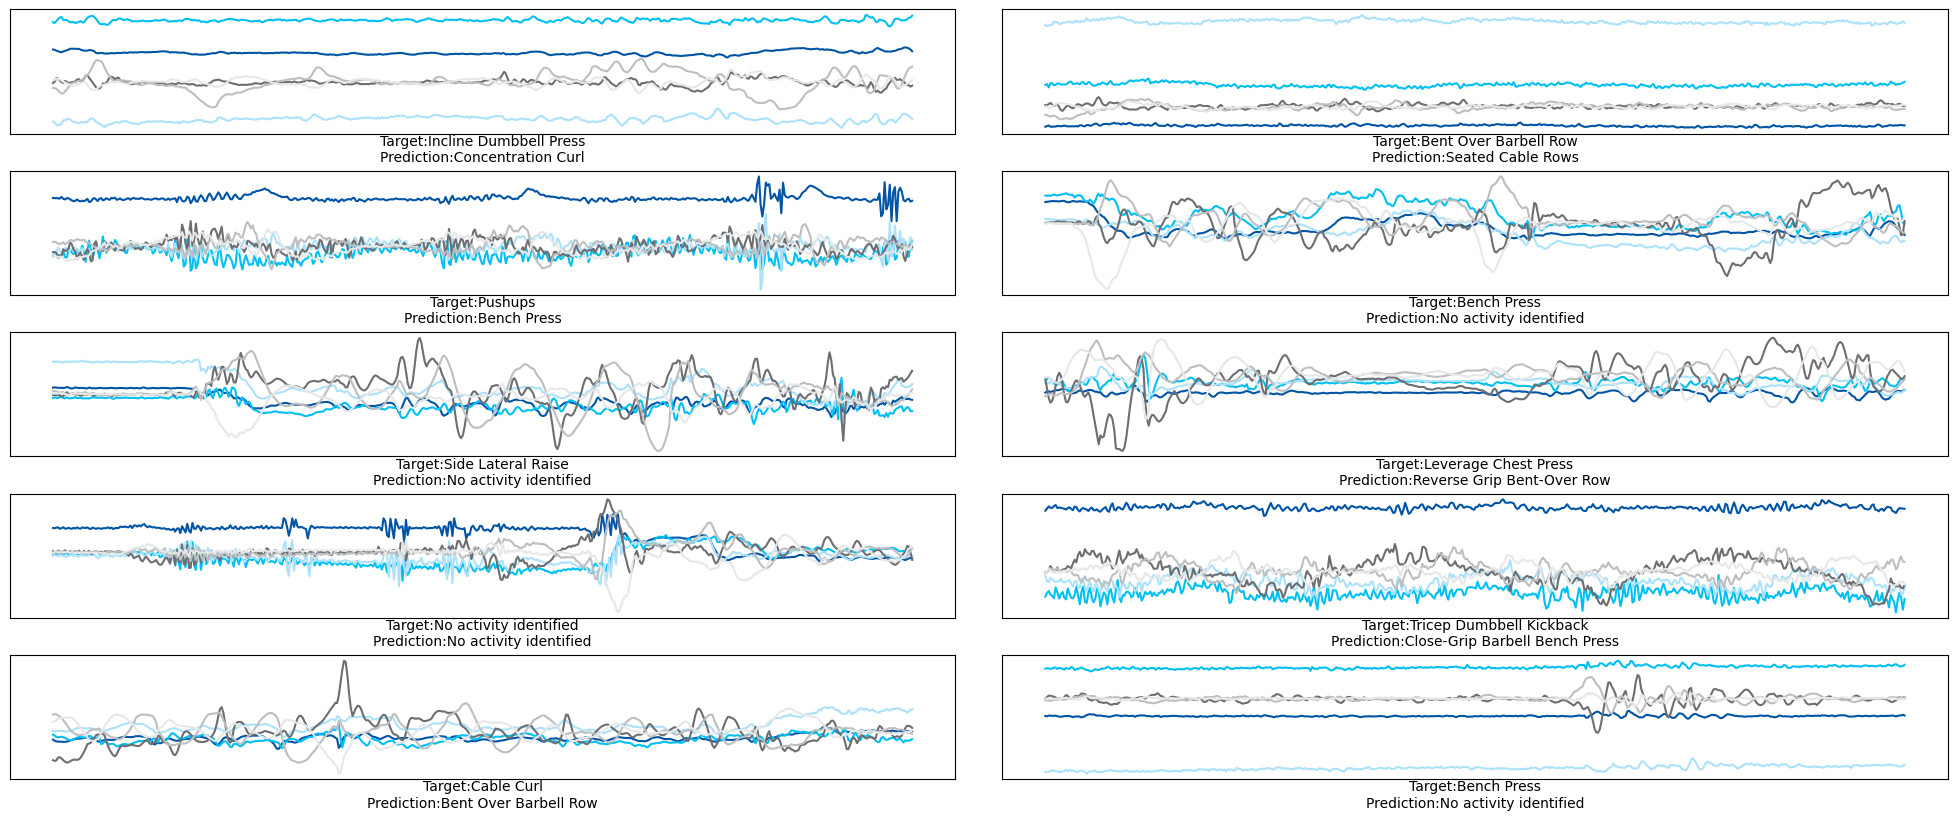

In [9]:
plot_samples(data = x1s_val, labels = y1s_val, predictions = predictions1)

We also plot a confusion matrix of the classifications. Observe just how poorly this method performs. The majority of missclassifications are towards the *No activity Identified* class. We could remove this class from consideration and consider the additional question of whether a time series corresponds to an activity or no activity.

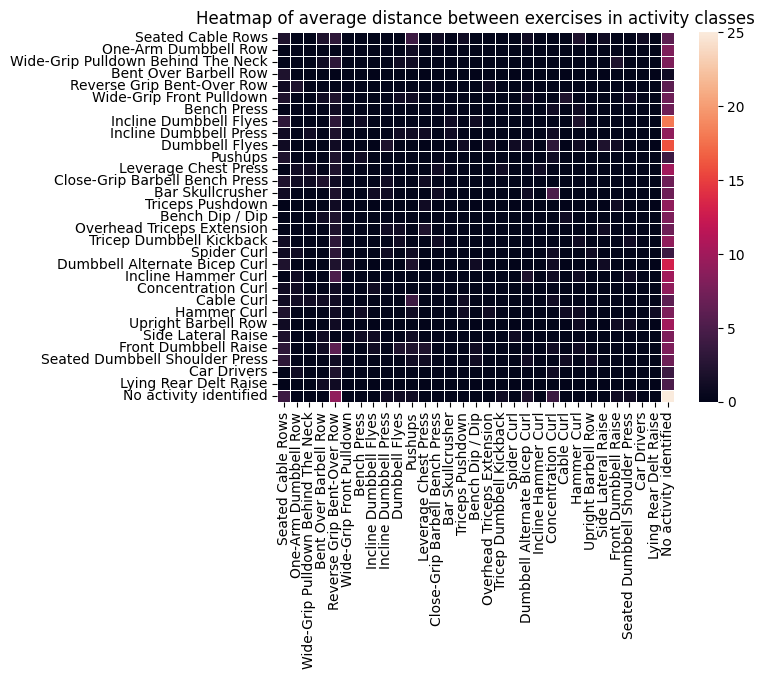

In [10]:
cm = confusion_matrix(y1s_val, predictions1, labels = classes)
ax = sns.heatmap(cm, linewidth=0.5, fmt=".2f", xticklabels=[ACTIVITY_MAPPING[c] for c in classes], yticklabels=[ACTIVITY_MAPPING[c] for c in classes])
ax.set_title('Heatmap of average distance between exercises in activity classes')
plt.show()

## Approach 2: K-Nearest Neighbour & DTW with samples

### Approach

Given the obvious shortcomings of using DTW Barycenters, we may elect to instead elect to improve classification performance (at the expense of compute time) by making use of all the observations. This is computationally infeasible, but we could take a subset of $\textit{n} \approx 10$ observations per class in place of using barycenters, and use the $\textit{k} \approx 3$ nearest neighbours, then examine the performance.

The rationale behind this is a single barycenter, no matter how well chosen, cannot effectively capture the heterogeneity of the train data for the class it represents.

### Training

In [11]:
# Configure the sample size per class, the number of k-nearest neighbours to use and the data indexes of the samples
n = 10
k = 3
data_idxs = np.array([], dtype = "int") # To be populated below

Select *n* samples from each class for our dataset.

In [12]:
for c in classes:
    class_idxs = np.where(y1s_train == c)[0]
    sample_idxs = np.random.choice(class_idxs, n, replace=False)
    data_idxs = np.concatenate([data_idxs, sample_idxs])

x = x1s_train[data_idxs, :, :]
y = y1s_train[data_idxs]

In [13]:
#Initiatise and fit the K-Nearest Neighbour classifier using the DTW metric
clf = KNeighborsTimeSeriesClassifier(n_neighbors=k, metric="dtw")
clf.fit(x, y)

KNeighborsTimeSeriesClassifier(n_neighbors=3)

### Prediction

In this context, the prediction operation is $O(knpq)$ where $k$ and $n$ are as described above.

In [14]:
N = len(y1s_val)
predictions2 = np.zeros(N)

In [15]:
start_time = time.time()
for idx in tqdm(range(N), desc = "Computing Nearest Neighbours"):
    data = x1s_val[idx, :, :]
    data = data[np.newaxis, :, :]
    prediction = clf.predict(data)
    predictions2[idx] = prediction
print("--- %s seconds ---" % (time.time() - start_time))
print("--- Average time per prediction: %s seconds ---" % ((time.time() - start_time)/N))

Computing Nearest Neighbours: 100%|██████████████████████████████████████████████████| 530/530 [10:42<00:00,  1.21s/it]

--- 642.2244930267334 seconds ---
--- Average time per prediction: 1.2117443264655348 seconds ---


In [16]:
# Compare predictions against the targets
print("Total predictions made: %s\nNumber of correct predictions: %s" % (N, sum(np.equal(predictions2, y1s_val))))

Total predictions made: 530
Number of correct predictions: 12


### Visualise Predictions

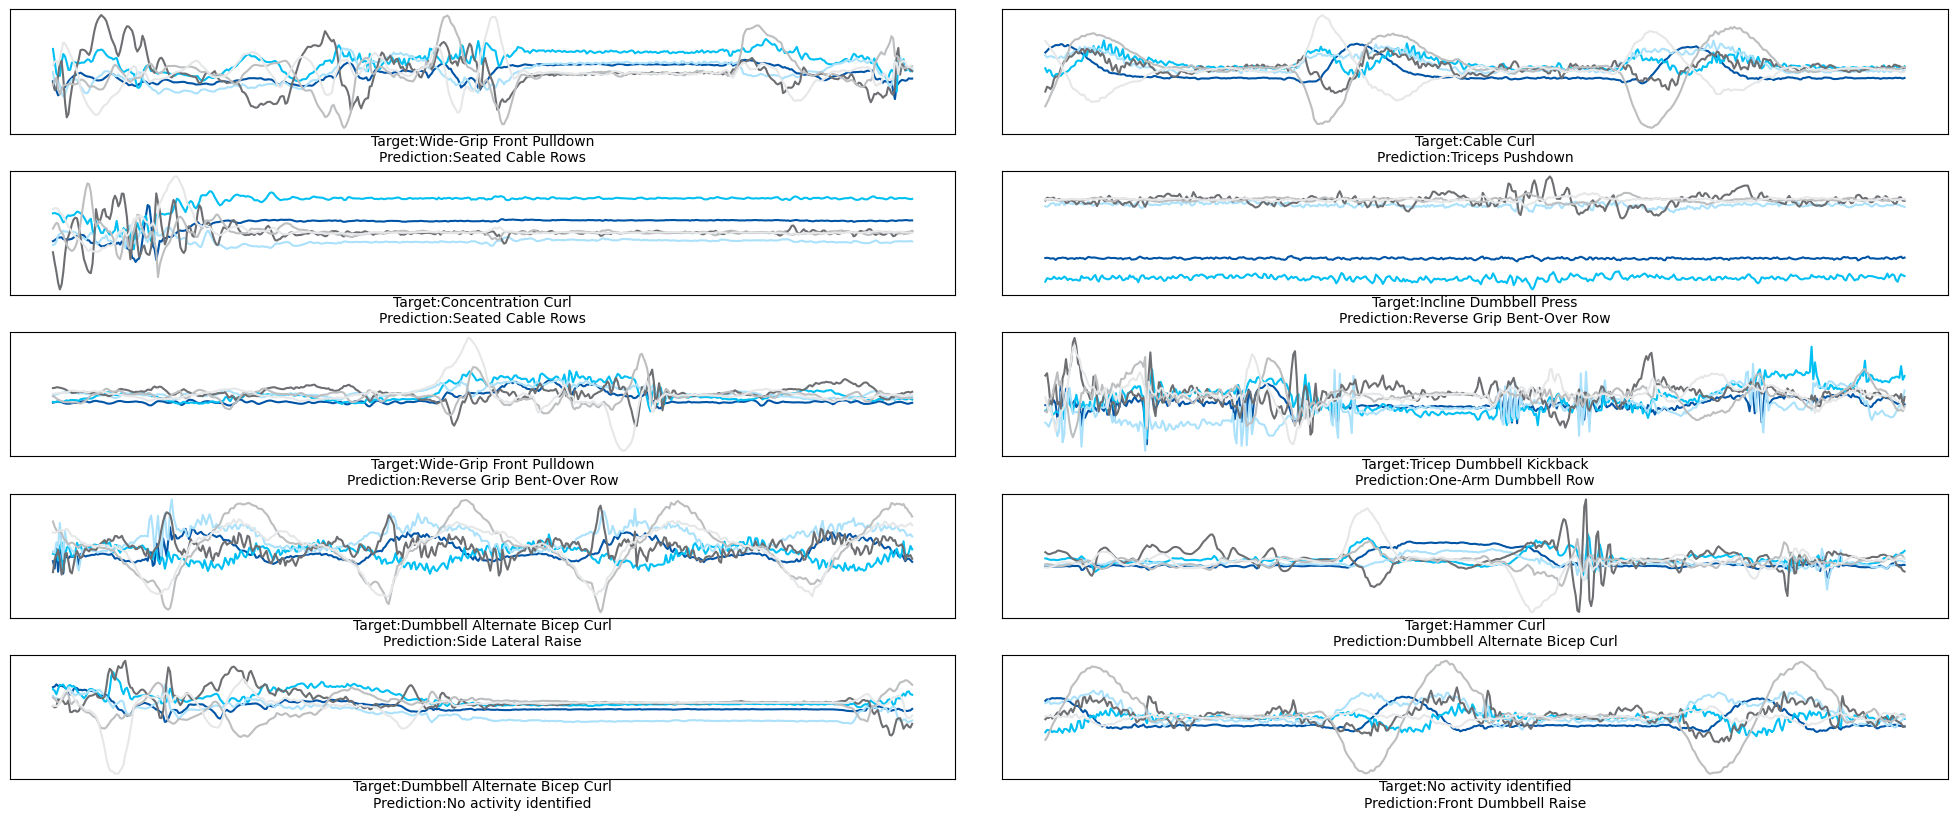

In [17]:
plot_samples(data = x1s_val, labels = y1s_val, predictions = predictions2)

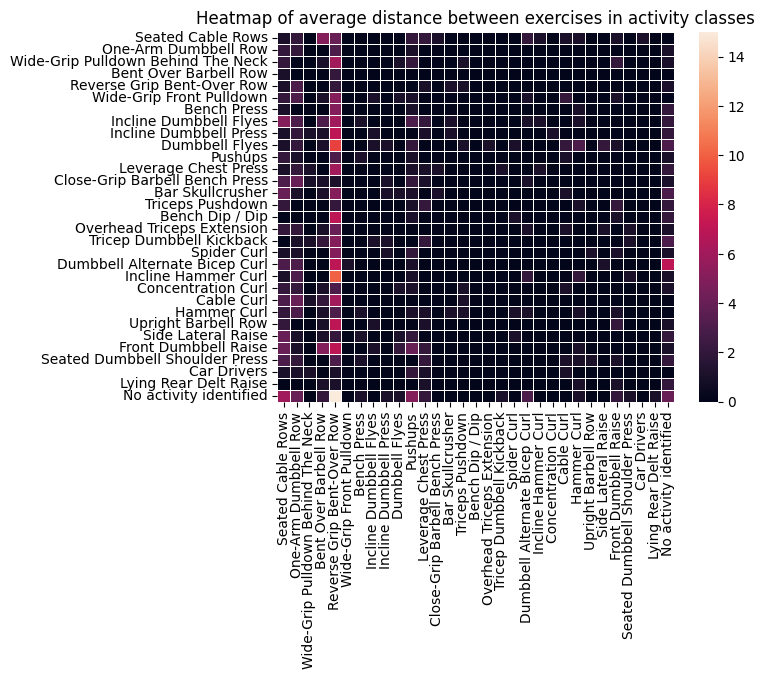

In [18]:
cm = confusion_matrix(y1s_val, predictions2, labels = classes)
ax = sns.heatmap(cm, linewidth=0.5, fmt=".2f", xticklabels=[ACTIVITY_MAPPING[c] for c in classes], yticklabels=[ACTIVITY_MAPPING[c] for c in classes])
ax.set_title('Heatmap of average distance between exercises in activity classes')
plt.show()

## References

[1] Petitjean, François, Alain Ketterlin and Pierre Gançarski. “A global averaging method for dynamic time warping, with applications to clustering.” Pattern Recognit. 44 (2011): 678-693.